# **주제: 서울 공유 자전거 이용 분석**

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

In [220]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/에폭/SeoulBikeDatanew.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8465 non-null   object 
 1   Rented Bike Count          8465 non-null   int64  
 2   Hour                       8465 non-null   int64  
 3   Temperature(°C)            8465 non-null   float64
 4   Humidity(%)                8465 non-null   int64  
 5   Wind speed (m/s)           8465 non-null   float64
 6   Visibility (10m)           8465 non-null   int64  
 7   Dew point temperature(°C)  8465 non-null   float64
 8   Solar Radiation (MJ/m2)    8465 non-null   float64
 9   Rainfall(mm)               8465 non-null   float64
 10  Snowfall (cm)              8465 non-null   float64
 11  Seasons                    8465 non-null   object 
 12  Holiday                    8465 non-null   int64  
 13  Day of Week                8465 non-null   objec

In [222]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day of Week,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,Friday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,Friday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,Friday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,Friday,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,Friday,0


datetime으로 변환

In [223]:
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

시간대 변수 object로 변환

In [224]:
#df["Hour"] = df["Hour"].astype(str)
#df.info()

In [225]:
df.describe()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Weekend
count,8465,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000,8465.000000,8465.000000
mean,2018-05-28 09:14:23.744831744,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,3.944997,0.567868,0.14912,0.077685,0.048198,0.288364
min,2017-12-01 00:00:00,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2018-02-27 00:00:00,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,-5.100000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2018-05-28 00:00:00,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,4.700000,0.010000,0.00000,0.000000,0.000000,0.000000
75%,2018-08-24 00:00:00,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,15.200000,0.930000,0.00000,0.000000,0.000000,1.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.00000,8.800000,1.000000,1.000000
std,NaN,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,13.242399,0.868245,1.12554,0.444063,0.214198,0.453028


**회귀**

In [226]:
# 계절별 데이터 분리
df_summer = df[df['Seasons'] == 'Summer']
df_winter = df[df['Seasons'] == 'Winter']

In [227]:
# 독립변수(X)와 종속변수(y) 설정
features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)']
X_summer = df_summer[features]
y_summer = df_summer['Rented Bike Count']

features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']
X_winter = df_winter[features]
y_winter = df_winter['Rented Bike Count']

In [228]:
from sklearn.linear_model import LinearRegression
# 모델 생성
lr_summer = LinearRegression()
lr_summer.fit(X_summer, y_summer)

lr_winter = LinearRegression()
lr_winter.fit(X_winter, y_winter)

# 회귀 계수 확인
print("Summer coefficients:", lr_summer.coef_)
print("Winter coefficients:", lr_winter.coef_)

Summer coefficients: [  -8.64619746  -21.11027806  181.09257954 -228.00616064  -35.02195808]
Winter coefficients: [ 12.5066706   -2.15312952   0.72600295 -11.23801575 -27.98345874
 -14.32697515]


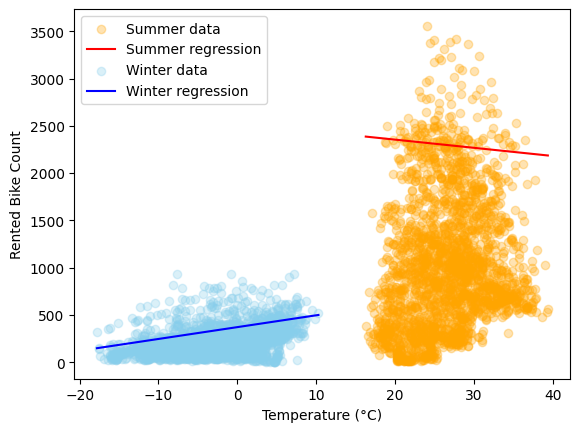

In [229]:
# 여름
temp_summer = np.linspace(X_summer['Temperature(°C)'].min(), X_summer['Temperature(°C)'].max(), 100).reshape(-1, 1)
pred_summer = lr_summer.intercept_ + lr_summer.coef_[0]*temp_summer  # 다른 변수 무시하면 이렇게 간단히 가능

# 겨울
temp_winter = np.linspace(X_winter['Temperature(°C)'].min(), X_winter['Temperature(°C)'].max(), 100).reshape(-1, 1)
pred_winter = lr_winter.intercept_ + lr_winter.coef_[0]*temp_winter

plt.scatter(X_summer['Temperature(°C)'], y_summer, color='orange', alpha=0.3, label='Summer data')
plt.plot(temp_summer, pred_summer, color='red', label='Summer regression')

plt.scatter(X_winter['Temperature(°C)'], y_winter, color='skyblue', alpha=0.3, label='Winter data')
plt.plot(temp_winter, pred_winter, color='blue', label='Winter regression')

plt.xlabel('Temperature (°C)')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()


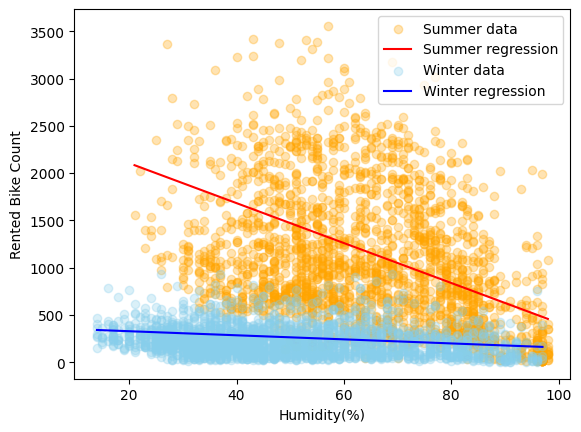

In [230]:
# 여름
temp_summer = np.linspace(X_summer['Humidity(%)'].min(), X_summer['Humidity(%)'].max(), 100).reshape(-1, 1)
pred_summer = lr_summer.intercept_ + lr_summer.coef_[1]*temp_summer  # 다른 변수 무시하면 이렇게 간단히 가능

# 겨울
temp_winter = np.linspace(X_winter['Humidity(%)'].min(), X_winter['Humidity(%)'].max(), 100).reshape(-1, 1)
pred_winter = lr_winter.intercept_ + lr_winter.coef_[1]*temp_winter

plt.scatter(X_summer['Humidity(%)'], y_summer, color='orange', alpha=0.3, label='Summer data')
plt.plot(temp_summer, pred_summer, color='red', label='Summer regression')

plt.scatter(X_winter['Humidity(%)'], y_winter, color='skyblue', alpha=0.3, label='Winter data')
plt.plot(temp_winter, pred_winter, color='blue', label='Winter regression')

plt.xlabel('Humidity(%)')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

계절에 따라 회귀선이 매우 다름.

모델 해석 측면 -> 변수의 개수를 줄이기 위해 라쏘 회귀

In [231]:
y = df['Rented Bike Count']
X = df[['Hour','Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
        'Visibility (10m)', 'Dew point temperature(°C)',
        'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']]

# 범주형 변수 인코딩
X = pd.get_dummies(X.join(df[['Seasons','Holiday','Weekend']]), drop_first=True)

# 학습용/테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [232]:
#스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [233]:
# 라쏘 회귀
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

# 예측
y_pred_lasso = lasso.predict(X_test_scaled)

# 평가
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)
print(f"Lasso MSE: {mse:.2f}, R2: {r2:.2f}")

Lasso MSE: 180505.49, R2: 0.57


In [240]:
#모델 예측이 우선이 아니므로
#from sklearn.linear_model import LassoCV
#lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
#lasso_cv.fit(X_train_scaled, y_train)
#print("최적 alpha:", lasso_cv.alpha_)

최적 alpha: 0.5822596853760491


In [243]:
#계수 시각화
lasso = Lasso(alpha=10)
lasso.fit(X_train_scaled, y_train)


coef = pd.Series(lasso.coef_, index=X.columns)
coef

,0
Hour,198.420580
Temperature(°C),265.445730
Humidity(%),-145.845651
Wind speed (m/s),0.000000
Visibility (10m),10.292467
Dew point temperature(°C),0.000000
Solar Radiation (MJ/m2),-33.184159
Rainfall(mm),-64.709020
Snowfall (cm),0.000000
Holiday,-18.057119


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


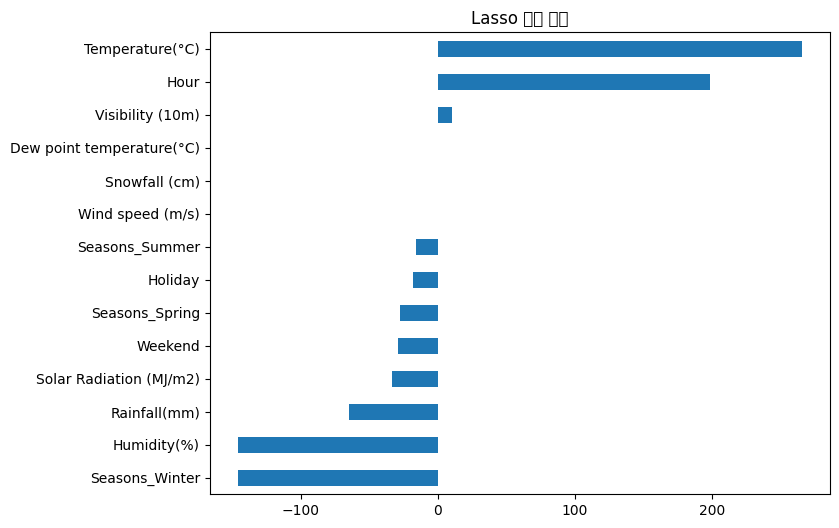

In [244]:
#계수 시각화
coef.sort_values().plot(kind='barh', figsize=(8,6))
plt.title('Lasso 회귀 계수')
plt.show()

대략적으로 어떤 변수가 영향을 주는지는 파악할 수 있음

설명력 57% -> 트리 기반 비선형모델 랜덤포레스트 사용하여 성능 높이기

온도로 예를 들면, 온도가 계속 높아진다고 해서 자전거 이용 수가 증가할 것 같지는 않음. 온도가 매우 높은 한여름엔 공유 자전거를 많이 이용하지 않을 것이라고 생각하여 비선형모델 사용

규제 큰 값(alpha=10)을 사용해 변수 선택

In [246]:
# Lasso에서 선택된 변수만 사용
# selected_features에 해당하는 컬럼 인덱스 찾기
cols_idx = [X_train.columns.get_loc(c) for c in selected_features]

X_train_selected = X_train_scaled[:, cols_idx]
X_test_selected = X_test_scaled[:, cols_idx]


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)

y_pred_rf = rf.predict(X_test_selected)

from sklearn.metrics import mean_squared_error, r2_score
print("RF MSE:", mean_squared_error(y_test, y_pred_rf))
print("RF R2:", r2_score(y_test, y_pred_rf))


RF MSE: 34707.06242711963
RF R2: 0.9166892168831338


RF MSE: 34735.95, R2: 0.9166


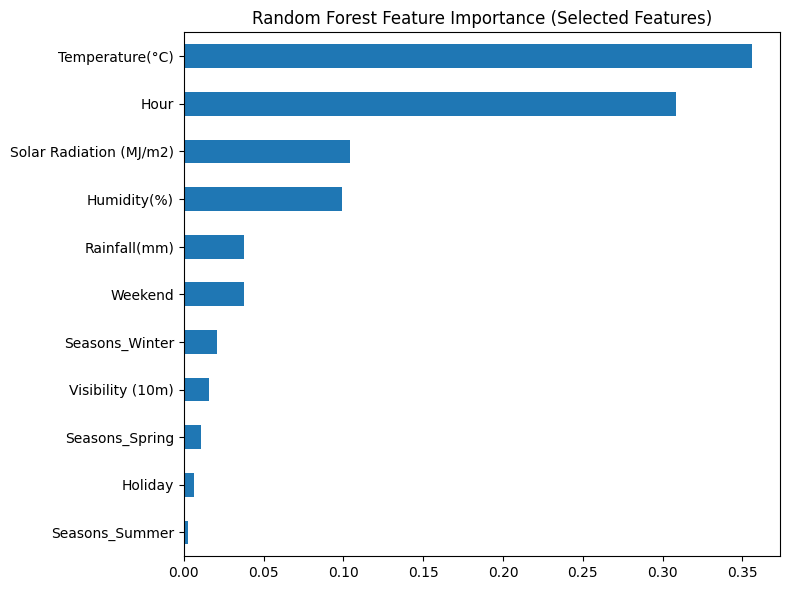

In [249]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=100,
    n_jobs=-1
)

rf.fit(X_train_selected, y_train)  # Lasso 선택 변수 사용
rf_pred = rf.predict(X_test_selected)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"RF MSE: {rf_mse:.2f}, R2: {rf_r2:.4f}")

# 변수 중요도 시각화
rf_importances = pd.Series(rf.feature_importances_, index=X_train_selected.columns).sort_values(ascending=True)

plt.figure(figsize=(8,6))
rf_importances.plot(kind='barh')
plt.title("Random Forest Feature Importance (Selected Features)")
plt.tight_layout()
plt.show()


비선형모델에서 성능이 약 92%으로 올라간 것을 확인할 수 있음.
온도변수와 시간대변수가 모델 성능에 큰 기여를 함

**다음 단계 아이디어**

**여름/겨울 구분 비교**

계절별로 Lasso → RF → feature importance 비교 → 계절별 영향력 분석 가능

**상관 관계 확인**

상위 변수들의 상관관계 확인 → 다중공선성이나 상호작용 체크

**예측 성능 향상 시도**

랜덤포레스트 하이퍼파라미터 튜닝 (max_depth, min_samples_leaf, n_estimators 등)


- Hour변수 타입에 대해서도 고민해볼 필요가 있음.